# Spatio-Temporal traffic speed predciton modeling
## Data cleaning

In [167]:
import os
import glob
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx
import numpy as np
#Directory
os.chdir("/Users/leomccarthy/Documents/Uni_GDS/Diss/Highways/Highways Data")

In [151]:
SensorLoc = pd.read_csv("SensorGeo.csv")


In [168]:
os.chdir("/Users/leomccarthy/Documents/Uni_GDS/Diss/Highways/Highways Data/Sensor Data")
#Load all files in data directory
all_filenames = [i for i in glob.glob('*.{}'.format('csv'))]
#combine all files in the list
sensor = pd.concat([pd.read_csv(f) for f in all_filenames ])

Impute missing time values

In [169]:
#Adjust inconsitent time values 
sensor["Report Date"] = sensor["Report Date"].apply(lambda x: x.replace("00:00:00",''))

rep14 = ['07','08','09','10','11','12','13','15','16','17','18','19','20','21']
rep29 = ['22','23','24','25','26','27','28','30','31','32','33','34','35','36']
rep44 = ['37','38','39','40','41','42','43','45','46','47','48','49','50','51']
rep59 = ['52','53','54','55','56','57','58','00','01','02','03','04','05','06']

 
for i in rep14:
    sensor.loc[sensor["Time Period Ending"].apply(lambda x:x[3:5]) == i,"Time Period Ending"] = sensor.loc[sensor["Time Period Ending"].apply(lambda x:x[3:5])==i,"Time Period Ending"].apply(lambda x: x.replace(i,"14"))

for i in rep29:
    sensor.loc[sensor["Time Period Ending"].apply(lambda x:x[3:5]) == i,"Time Period Ending"] = sensor.loc[sensor["Time Period Ending"].apply(lambda x:x[3:5])==i,"Time Period Ending"].apply(lambda x: x.replace(i,"29"))


for i in rep44:
    sensor.loc[sensor["Time Period Ending"].apply(lambda x:x[3:5]) == i,"Time Period Ending"] = sensor.loc[sensor["Time Period Ending"].apply(lambda x:x[3:5])==i,"Time Period Ending"].apply(lambda x: x.replace(i,"44"))


for i in rep59:
    sensor.loc[sensor["Time Period Ending"].apply(lambda x:x[3:5]) == i,"Time Period Ending"] = sensor.loc[sensor["Time Period Ending"].apply(lambda x:x[3:5])==i,"Time Period Ending"].apply(lambda x: x.replace(i,"59"))




In [170]:
sensor["Report Date"] = sensor["Report Date"].apply(lambda x: x.replace("00:00:00",'')) + sensor["Time Period Ending"]
sensor["Report Date"] = sensor["Report Date"].apply(lambda x:datetime.strptime(x,'%d/%m/%Y %H:%M:%S'))
sensor["Report Date"] = sensor["Report Date"].dt.floor('T')
sensor["Time Period Ending"] = [x[:5] for x in sensor["Time Period Ending"]]
sensor.drop_duplicates(keep = "first", subset = ["Site Name","Report Date"], inplace = True)

In [171]:
sensor = sensor.loc[sensor["Site Name"].isin(spd.iloc[:,:21].columns.values)]

In [183]:
spd.columns

Index(['M60/9171A', 'M60/9179A', 'M60/9187A', 'M60/9192A', 'M60/9195A',
       'M60/9196K', 'M60/9205A', 'M60/9206A', 'M60/9209A', 'M60/9210J',
       'M60/9213A', 'M60/9223A', 'M60/9229L', 'M60/9242A', 'M60/9262A',
       'M60/9277A', 'M60/9288A', 'M60/9292A', 'M60/9298K', 'M60/9304A',
       'M60/9309A'],
      dtype='object', name='Site Name')

Impute missing Mph Values. For the 4810(0.9%) missing values replace with the average speed for that sensor at that time on that day of the week.

In [224]:
sensor["dayofweek"] = sensor["Report Date"].dt.dayofweek + 1
sensor["Sensor Overall Mean"] = sensor.groupby(["Site Name","dayofweek","Time Interval"])["Avg mph"].transform('mean')
sensor["Avg mph"].fillna(sensor["Sensor Overall Mean"], inplace = True)

In [225]:
spd = sensor.pivot(index='Report Date', columns='Site Name', values='Avg mph')
spd.interpolate("time", inplace = True)
sensor = sensor.loc[sensor["Site Name"].isin(spd.iloc[:,:21].columns.values)]
spd = spd.iloc[:,:21]

In [165]:
sensor = pd.read_csv("sensor.csv")

In [127]:
spd.to_csv("sensor_time_series.csv")
sensor.to_csv("sensor.csv")

In [92]:
gdf["Avg mph mean"] = sensor.groupby("Site Name")["Avg mph"][1][:21].values

IndexError: Column(s) Avg mph already selected

In [45]:
import libpysal as lb

In [88]:
w_knn = lb.weights.KNN.from_dataframe(gdf, k=3)

In [89]:
from esda.moran import Moran 
mi = Moran(np.array(gdf["Avg mph mean"]), w_knn)

In [90]:
mi.I

-0.06640147142300391

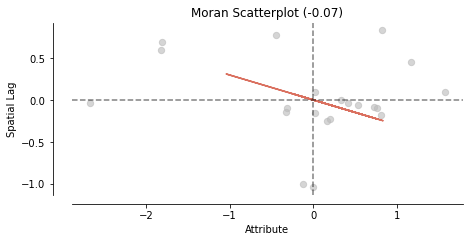

In [91]:
from splot.esda import moran_scatterplot

fig, ax = moran_scatterplot(mi, aspect_equal=True)
plt.show()

## Exploration

Sensor locations

In [128]:
import geopandas
gdf = geopandas.GeoDataFrame(
    SensorLoc, geometry=geopandas.points_from_xy(SensorLoc.Long, SensorLoc.Lat), crs = 'EPSG:4326')

In [129]:
gdf = gdf.to_crs("EPSG:3857")

In [130]:
gdf.to_csv("SensorGeo.csv")

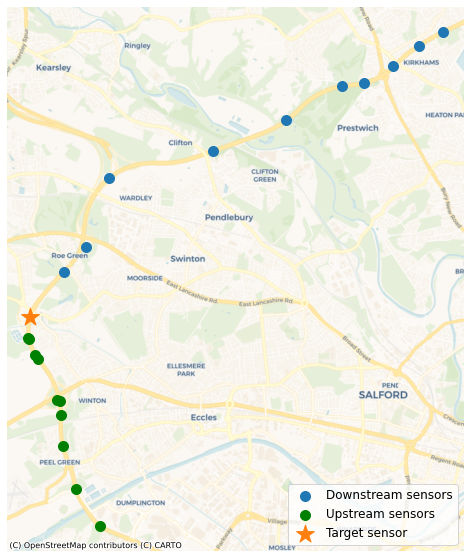

In [212]:
#Set directroy for plots
os.chdir("/Users/leomccarthy/Documents/Uni_GDS/Diss/Highways/Plots")

fig, ax = plt.subplots(figsize = (15,10))
plt.scatter(gdf.geometry.x[11:21],gdf.geometry.y[11:21], s= 100)
plt.scatter(gdf.geometry.x[:10],gdf.geometry.y[:10], s= 100, color = "green")
plt.scatter(gdf.geometry.x[10],gdf.geometry.y[10], marker = "*",s = 350)
cx.add_basemap(ax,
               crs="EPSG:3857",
               source=cx.providers.CartoDB.Voyager, zoom = 13
              )
ax.legend(["Downstream sensors","Upstream sensors","Target sensor"], loc = 4, fontsize = "large")
ax.set_axis_off()
plt.savefig('sensor_locations.png', bbox_inches = 'tight', dpi = 600)


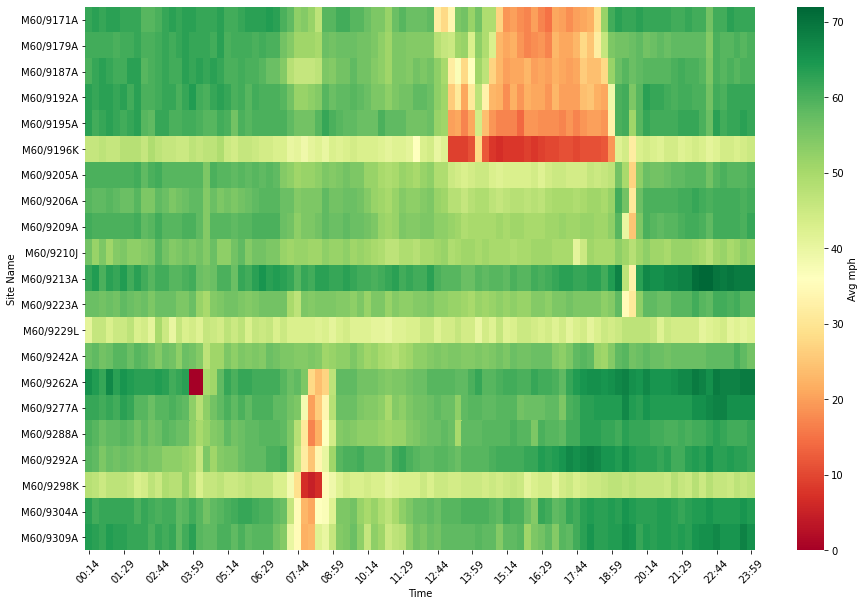

In [248]:
date = '2019-09-06'

plt.figure(figsize = (15,10))
g = sns.heatmap(spd[date].T, cmap='RdYlGn',xticklabels=5,cbar_kws={'label': 'Avg mph'})
xlabs = [x.get_text()[11:16] for x in g.get_xticklabels()]
g.set_xticklabels(xlabs,rotation=45)
g.set(xlabel='Time', ylabel='Site Name')
plt.savefig('heatmap_highways.png', bbox_inches = 'tight', dpi = 600)


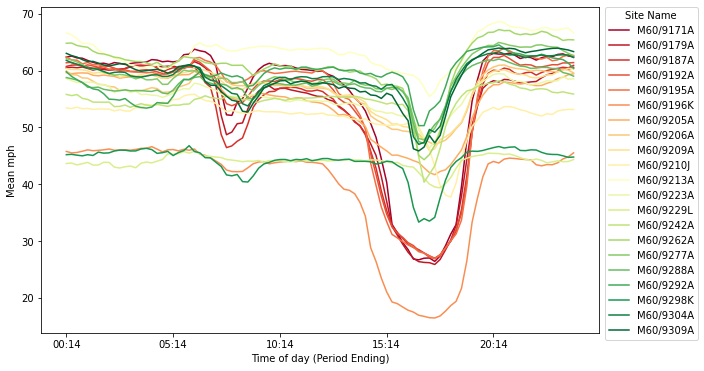

In [249]:
fig, ax = plt.subplots(figsize=(10,6))
sensor.groupby(["Time Period Ending","Site Name"])["Avg mph"].mean().unstack().plot(ax=ax, cmap = "RdYlGn")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, title = "Site Name")
plt.xlabel("Time of day (Period Ending)")
plt.ylabel("Mean mph")
plt.savefig('avg_by_time.png', bbox_inches = 'tight', dpi = 600)

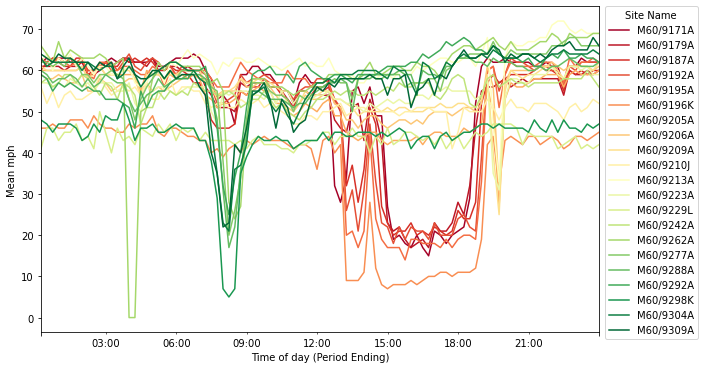

In [250]:
fig, ax = plt.subplots(figsize=(10,6))
spd[date].plot(ax=ax, cmap = "RdYlGn")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, title = "Site Name")
plt.xlabel("Time of day (Period Ending)")
plt.ylabel("Mean mph")
plt.savefig('avg_by_time_sep.png', bbox_inches = 'tight', dpi = 600)

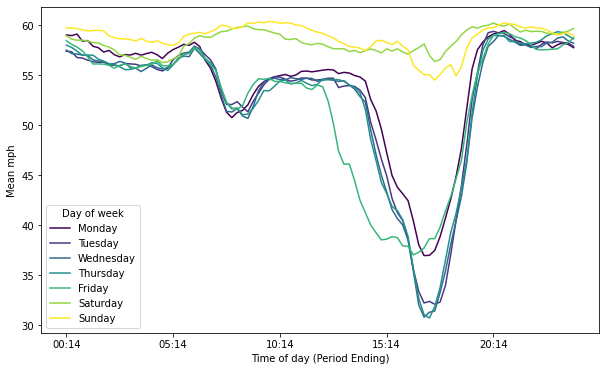

In [253]:
fig, ax = plt.subplots(figsize=(10,6))
sensor.groupby(["Time Period Ending","dayofweek"])["Avg mph"].mean().unstack().plot(ax=ax, cmap = 'viridis')
plt.legend(title = "Day of week", labels = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.xlabel("Time of day (Period Ending)")
plt.ylabel("Mean mph")
plt.savefig('avg_by_day.png', bbox_inches = 'tight', dpi = 600)

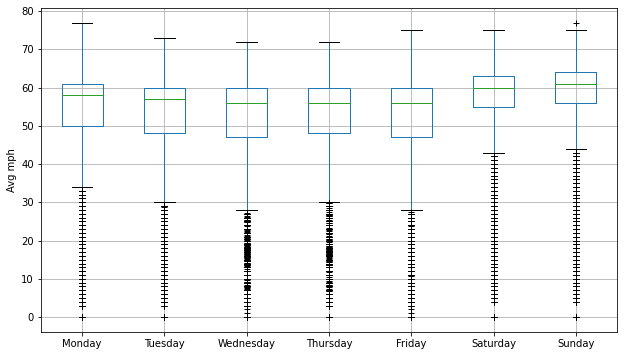

In [256]:
sensor.boxplot(column = "Avg mph", by = "dayofweek", figsize = (10,6), sym = '+')
plt.xticks([1,2,3,4,5,6,7],["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.xlabel("")
plt.ylabel("Avg mph")
plt.title("")
plt.suptitle("")
plt.savefig('box.png', bbox_inches = 'tight', dpi = 600)

In [ ]:
f = sensor.boxplot(column = "Avg mph", by = "Site Name", figsize = (15,10), sym = '+')
plt.xticks(rotation=45)

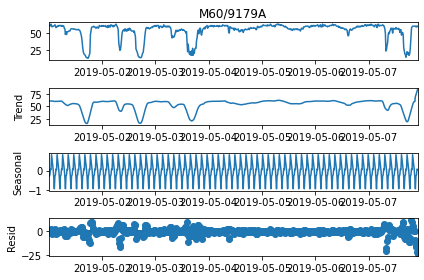

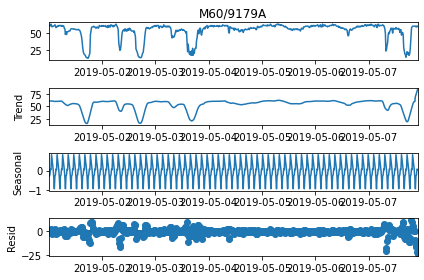

In [321]:
from statsmodels.tsa.seasonal import seasonal_decompose
#fig,ax = plt.subplots(figsize = (15,10))
result = seasonal_decompose(series[:664],extrapolate_trend='freq', period = 10)
result.plot()